In [1]:
import sys
import os
from pathlib import Path

import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 96

from sklearn.utils import Bunch

sys.path.insert(0, os.path.abspath(".."))

from seldon.ambiguity.new_ambiguity import new_ambiguity as ambiguity_measure
from seldon.ambiguity.posterior.new_ambiguity import var_amb
from seldon.estimator import Estimator, BayesEstimator
from seldon.utils.binning import bin_values
import seldon.ambiguity.estimator as estimators
import seldon.utils.sampling as sampling_utils

In [2]:
EstimationType = BayesEstimator.EstimatorType

In [3]:
def linestyles():
    _linestyles = [
        "solid",
        "dotted",
        "dashed",
        "dashdot"
    ]
    idx = 0
    while True:
        yield _linestyles[idx % len(_linestyles)]
        idx += 1

In [4]:
def out_path(*parts) -> Path:
    p = Path("out", *parts)
    p.parent.mkdir(parents=True, exist_ok=True)
    return p

In [5]:
def compute_biases(estimator: Estimator, sample_sizes: list[int], q0: np.ndarray, **kwargs) -> np.ndarray:
    estimator_means = np.vstack([
        estimator.expectation(num_trials=R, q0=q0, **kwargs)
        for R in sample_sizes
    ]).T
    
    bias = estimator_means - ambiguity_measure(q0).reshape(-1, 1)
    return bias

In [6]:
q0 = np.array([
    [0.5, 0.4, 0.1],
    [0.01, 0.95, 0.04],
    [0, 0.1, 0.9]
])

sample_sizes = list(range(1, 31))

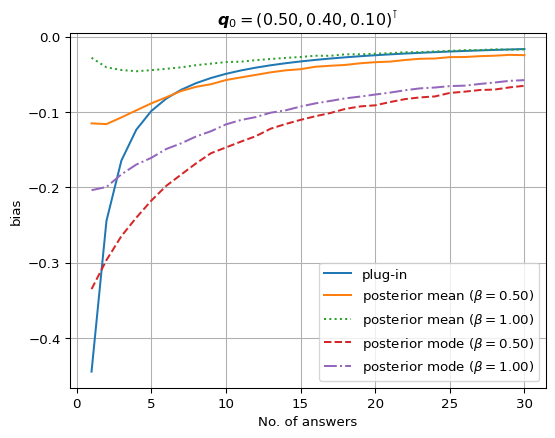

In [7]:
idx = 0
always_show_legend = False

fig, ax = plt.subplots()

plugin_estiamtor = estimators.NewAmbiguityPlugInEstimator()
selected_biases = compute_biases(estimator=plugin_estiamtor, sample_sizes=sample_sizes, q0=q0)[idx]

ax.plot(sample_sizes, selected_biases, label="plug-in")

settings = [
    Bunch(beta=0.5, estimator_type=EstimationType.MEAN),
    Bunch(beta=1.0, estimator_type=EstimationType.MEAN),
    Bunch(beta=0.5, estimator_type=EstimationType.MODE),
    Bunch(beta=1.0, estimator_type=EstimationType.MODE),
]

for linestyle, setting in zip(linestyles(), settings):
    label = "$\\beta="+f"{setting.beta: .2f}"+"$"
    label = f"posterior {'mean' if setting.estimator_type == EstimationType.MEAN else 'mode'} ({label})"
    _selected_biases = compute_biases(
        estimator=estimators.NewAmbiguityBayesianEstimator(**setting),
        sample_sizes=sample_sizes,
        q0=q0,
        repeats=4
    )[idx]
    ax.plot(sample_sizes, _selected_biases, linestyle=linestyle, label=label)

ax.grid(True)
ax.set_xlabel("No. of answers")
ax.set_ylabel("bias")
if always_show_legend or idx < 1:
    ax.legend()

q0_str = ",".join([f"{x:.2f}" for x in q0[idx].tolist()])
ax.set_title("$\\boldsymbol{q}_0 = (" + q0_str + ")^{\\intercal}$")
    
fig.savefig(out_path("bias", f"dist{idx}.pdf"), bbox_inches="tight")
plt.show()

**Choice of $\beta$ based on prior variance**.

In [8]:
selected_betas = [0.5, 1.0, 2.0]
selected_num_classes = 5

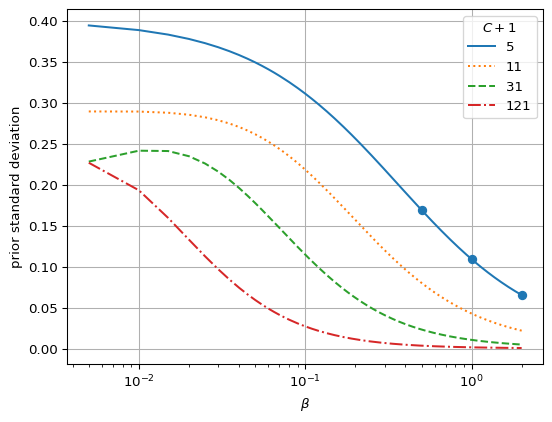

In [12]:
num_classes = [5, 11, 31, 121]
betas = np.linspace(0, 2, 401)[1:]
stds = []
for nc in num_classes:
    alphas = np.repeat(betas.reshape(-1, 1), repeats=nc, axis=-1)
    stds.append(np.sqrt(var_amb(alphas)))

fig, ax = plt.subplots()

for linestyle, nc, std in zip(linestyles(), num_classes, stds):
    ax.plot(betas, std, linestyle=linestyle, label=nc)

    if nc == selected_num_classes:
        _selected_betas = np.array(selected_betas).reshape(-1, 1)
        argmins = np.abs(_selected_betas - betas.reshape(1, -1)).argmin(axis=-1)
        _selected_stds = std[argmins]
        ax.scatter(_selected_betas, _selected_stds, marker="o", zorder=4)
    
ax.legend(title="$C+1$")
ax.set_xscale("log")
ax.set_xlabel("$\\beta$")
ax.set_ylabel("prior standard deviation")
ax.grid(True)

fig.savefig(out_path("std_vs_beta.pdf"), bbox_inches="tight")
plt.show()

For each of the chosen values for beta (and a fixed number of repeats), we plot the prior density of the ambiguity.

In [10]:
def approximate_prior_density(beta: float, num_classes: int) -> tuple[np.ndarray, np.ndarray]:
    
    sample = sampling_utils.sample_from(
        f=ambiguity_measure,
        alphas=np.full((512, num_classes), fill_value=beta),
        repeats=10_000
    ).vals
    
    res = bin_values(sample)
    bin_centers = res.bin_centers

    # Convert counts to density
    densities = (1 / res.bin_width) * res.counts / res.counts.sum(axis=-1, keepdims=True)
    density = densities.mean(axis=0)

    # Compute mode
    argmax = density.argmax()
    mode = bin_centers[argmax]
    max_density = density[argmax]
    
    return Bunch(
        point=(mode, max_density),
        curve=(bin_centers, density)
    )

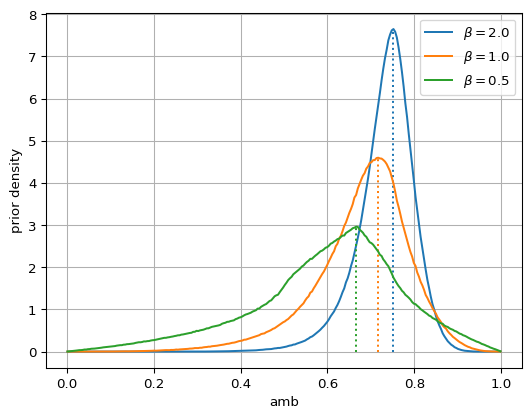

In [11]:
fig, ax = plt.subplots()

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for color, (beta, approx) in zip(
    colors,
    map(lambda beta: (beta, approximate_prior_density(beta=beta, num_classes=selected_num_classes)), selected_betas[::-1])
):
    x, y = approx.point
    ax.plot(*approx.curve, color=color, label="$\\beta="+f"{beta:.1f}"+"$")
    ax.vlines(x=x, ymin=0, ymax=y, color=color, linestyle="dotted")

ax.set_xlabel("amb")
ax.set_ylabel("prior density")

ax.grid(True)
ax.legend()
fig.savefig(out_path("prior_densities.pdf"), bbox_inches="tight")
plt.show()

As can be seen, the uniform prior on the probability vectors leads to a prior of ambiguity that is skewed towards larger values and has a small standard deviation for larger values of $\beta$, in line with the previous plot.